# Logistic regression: Multiclass classification and Regularization

In this notebook, we cover an example of applying Logistic regression to classify data into more than two classes. We also apply regularization to logistic regression cost function and gradient function.

<p>For example of binary classification, refer <a href="1_binary_classification.ipynb">Logistic regression: Binary classification</a>
<p>For example of regularization on linear refression, refer: <a href="../1_linear_regression/2_multiple_variables_reg.ipynb">Linear regression: Multiple variables with Regularization</a>

## Dataset: Alphabets

Original source: https://archive.ics.uci.edu/ml/datasets/Letter+Recognition

In this dataset, we have 16 features which can be used to identify one of the 26 possible english alpabets. The 16 features are generated by using different fonts, adding noise and then taking 16 unique components of the result. Each of the 16 features are scaled to values 0-15.

Attribute information:
1.	lettr	capital letter	(26 values from A to Z) 
2.	x-box	horizontal position of box	(integer) 
3.	y-box	vertical position of box	(integer) 
4.	width	width of box	(integer) 
5.	high height of box	(integer) 
6.	onpix	total # on pixels	(integer) 
7.	x-bar	mean x of on pixels in box	(integer) 
8.	y-bar	mean y of on pixels in box	(integer) 
9.	x2bar	mean x variance	(integer) 
10.	y2bar	mean y variance	(integer) 
11.	xybar	mean x y correlation	(integer) 
12.	x2ybr	mean of x * x * y	(integer) 
13.	xy2br	mean of x * y * y	(integer) 
14.	x-ege	mean edge count left to right	(integer) 
15.	xegvy	correlation of x-ege with y	(integer) 
16.	y-ege	mean edge count bottom to top	(integer) 
17.	yegvx	correlation of y-ege with x	(integer)

The first attribute is the class, which we need to build the model for. The rest of the attributed are the input features.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import math
from sklearn import preprocessing

%matplotlib inline

In [17]:
data = pd.read_csv('letter-recognition.data', header=None)
print(data.shape)
data.head()

(20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


## One-vs-all Classification
The one-vs-all classification is basically an extension to binary classification. Where binary classification can help us classify whether a given example belongs to class 0 or class 1, we can use $K$ binary classifiers to identify if a given example belongs to class $k$ or not. However, only one of the $K$ classifiers should result in positive output in order to unambiguously classify an example to one of the classes.

In other words, we can build $K$ classifiers for $K$ classes, where each classifier would tell us whether an example is positive or negative for that particular classifier. By applying all $K$ classifiers on the example, we can put the example in one of the $K$ classes which tests out positive.

In this example, we will build 26 classifiers.

## Cost function and gradient descent

We could use the same cost function and gradient descent algorithms as binary classification. However, we are going to add a regularization term to them.

The new cost function with regularization term is:

$$
J = -\frac1m \sum_{i=1}^m {y^{(i)}.log(h_\theta(x^{(i)}) + (1-y^{(i)})log(1 - h_\theta(x^{(i)}) } + \frac \lambda {2m} \sum_{j = 1}^n \theta_j^2
$$

And our new gradient function with regularization is:

$$
grad_j = \frac 1m \sum_{1=1}^m ( h_\theta(x^{(i)}) - y^{(i)}).x_1^{(i)} + \frac \lambda m \theta_j
$$

where j = 1,2,...n (not 0,1,..n)


In [18]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Hypothesis function
def hypothesisLogisticRegression(theta, X):
    sig = np.vectorize(sigmoid)
    theta = theta.reshape(X.shape[1], 1) # optimizer rehsapes it to row vector, so we reshape it back to column vector
    return sig(np.dot(X, theta))

# Logistic regression cost function
def costLogisticRegression(theta, X, y, lmbda):
    H = hypothesisLogisticRegression(theta, X)
    m, n = X.shape
    theta = theta.reshape(n, 1) # optimizer rehsapes it to row vector, so we reshape it back to column vector
    J = (-1/m) * ( np.dot(y.T, np.log(H)) + np.dot((1-y).T, np.log(1 - H)) )
    
    theta_ = np.copy(theta)
    theta_[0][0] = 0
    reg = (lmbda / (2*m)) * np.dot(theta_.T, theta_)
    J = J + reg
    
    return J

# Gradient function to be used by optimizer
def gradLogisticRegression(theta, X, y, lmbda):
    H = hypothesisLogisticRegression(theta, X)
    m, n = X.shape
    grad = (1/m) * (np.dot( (H - y).T , X ).T)
    
    theta = theta.reshape(n, 1) # optimizer rehsapes it to row vector, so we reshape it back to column vector
    theta_ = np.copy(theta)
    theta_[0][0] = 0
    reg = (lmbda / m) * theta_
    grad = grad + reg
    
    return grad

# Gradient descent - optimizes cost
def gradientDescentLogisticRegression(theta_init, X, y, maxiter, lmbda):
    res = op.minimize(fun = costLogisticRegression, 
                                 x0 = theta_init, 
                                 args = (X, y, lmbda),
                                 method = 'TNC',
                                 jac = gradLogisticRegression,
                                 options = {
                                    'maxiter': maxiter,
                                    'disp': True #  No idea why its not working
                                    }
                                 );
    return res.x # optimal theta

In order to visualize the convergence of cost when using gradient descent, we are going to create a wrapper function for gradient descent that will divide the iterations into, say 100 parts and perform gradient descent for each of the part while calculating the intermediate costs after each one. For example, if we are runnnig gradient descent for total of 500 iterations, the wrapper function will run first 5 iterations, calculate cost, then run next 5 iterations, calculate cost, and so on.

This way we can plot a graph for intermediate costs and visualize that the cost is actually converging.

In [43]:
# Gradient descent wrapper function. Partitions the input number of iterations
# and calculates intermediate costs for each partition
# Note: 'maxiter' should be an exact multiple of 'partitions'
def gradientDescentWrapper(theta_init, X, y, maxiter, lmbda, partitions):
    partition_size = int(maxiter / partitions)
    theta_init_next = np.copy(theta_init)
    cost_history = np.zeros(partitions)
    
    for i in range(partitions):
        theta_i = gradientDescentLogisticRegression(theta_init_next, X, y, partition_size, lmbda)
        cost_history[i] = costLogisticRegression(theta_i, X, y, lmbda)
        theta_init_next = np.copy(theta_i)
    
    return (cost_history, theta_init_next)

## Applying algorithm on data

Now we can apply one-vs-all training algorithm on our data by looping through $K$ labels (26 in this example) and preparing a $\Theta$ which contains one column for each $\theta$, which represents one label.

Training : [A...B...C...D...E...F...G...H...I...J...K...L...M...N...O...P...Q...R...S...T...U...V...W...X...Y...Z...]

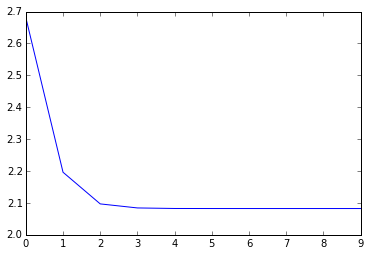

In [57]:
# Extract into separate matrices for input and output
data = np.matrix(data)

# Important to shuffle data before beginning, as input data may be biased towards
# some particular classes in the beginning - depending on the method used to obtain examples
np.random.shuffle(data) 

X = data[:,1:17]
y = data[:,0]
y = np.reshape(y, (y.shape[0], 1))

# Convert to range 0 - 25 ('A' -> 0, 'Z' -> 25)
ord_ = np.vectorize(ord)
y = ord_(y) - 65 

total_size = X.shape[0]
training_set_size = int(total_size * (0.8))
test_set_size = total_size - training_set_size

Xtrain = X[0:training_set_size, :]
XtrainNorm = preprocessing.scale(Xtrain.astype(np.float64)) # normalize to mean = 0 and unit variance
XtrainNorm = np.append(np.ones((XtrainNorm.shape[0],1)), XtrainNorm, axis = 1)
ytrain = y[0:training_set_size]

Xtest = X[(training_set_size):(training_set_size + test_set_size), :]
XtestNorm = preprocessing.scale(Xtest.astype(np.float64)) # normalize to mean = 0 and unit variance
XtestNorm = np.append(np.ones((XtestNorm.shape[0],1)), XtestNorm, axis = 1)
ytest = y[(training_set_size): (training_set_size + test_set_size)]

num_labels = 26
m,n = XtrainNorm.shape
maxiter = 100
Theta = np.zeros((n, num_labels))
lmbda = 0.3

partitions = 10
cost_history = np.zeros((num_labels, partitions))

print("Training : [", end="")
for k in range(num_labels):
    print(chr(k + 65) + "...", end="")
    theta_init_k = np.zeros((n, 1))
    # theta_k = gradientDescentLogisticRegression(theta_init_k, XtrainNorm, (ytrain == k) , maxiter, lmbda)
    cost_history[k], theta_k = gradientDescentWrapper(theta_init_k, XtrainNorm, (ytrain == k) , maxiter, lmbda, partitions)
    Theta[:,k] = np.copy(theta_k)
print("]", end="")

plt.plot(np.sum(cost_history, axis = 0))

## Calculating accuracy

Once we have the value for $\Theta$, we can predict each training and test example, and cross verify with ground truth to find out the accuracy of the model.

Following function uses $\Theta$ to calculate probabilities of each example for each labal class, and then predicts class having highest probability as the hypothesis for that example:

In [58]:
# Prediction function
def predictOneVsAll(Theta, X):
    # Theta -> n x K
    # X -> m x n
    # H -> m x K
    sig = np.vectorize(sigmoid)
    H = sig(np.dot(X, Theta))
    pred = np.argmax(H, axis = 1)
    pred = pred.reshape(pred.shape[0], 1)
    return pred

To calculate accuracies, we will apply the above function to training and test sets:

In [59]:
pred_train = predictOneVsAll(Theta, XtrainNorm)
pred_test = predictOneVsAll(Theta, XtestNorm)

def accuracy(pred, y):
    m = y.shape[0]
    acc = sum(pred == y) / m
    return acc

acc_train = accuracy(pred_train, ytrain)
acc_test = accuracy(pred_test, ytest)
print("Training accuracy for " + str(training_set_size) + " samples (percentage)", acc_train * 100)
print("Test accuracy for " + str(test_set_size) + " samples (percentage)", acc_test * 100)

Training accuracy for 16000 samples (percentage) [[ 72.24375]]
Test accuracy for 4000 samples (percentage) [[ 72.25]]
